## Gradient Descent to Adam and More
This notebook contains implementations of the Adam optimizer and the key algorithms prior to it. These include Gradient Descent, Momentum, Adagrad, and RMSprop. Further, existing variations of Adam, such as Adamax and AdaBelief, are implemented. The goal is to minimize an arbitrary function and look into the steps that were taken by each algorithm.

Supporting materials:
<br>
_[Automatic differentiation in deep learning](https://mdrk.io/automatic-differentiation-4/) (article on implementing automatic differentiation in python)_ 
<br>
_[Andrej Karpathy's repository](https://github.com/karpathy/micrograd/tree/master/micrograd) (micrograd)_
<br>
_[Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980) (original paper on Adam)_ 
<br>
_[A journey into Optimization algorithms for Deep Neural Networks](https://theaisummer.com/optimization/) (a nice artice on the math behind neural network optimizers)_

_Note: Differentiation will be taken care by an automatic differentiation class._

### Automatic Differentiation Class

In [65]:
import numpy as np

class Variable():
    def __init__(self, f, d = 0):
        self.f = f  # for function evaluation f(x)
        self.d = d  # for the derivative f'(x)

    def __repr__(self):
        return f"Variable(f = {self.f}, d = {self.d})"

    # if the value is a constant, it passes it directly to the function when .f is called and makes it 0 when .d is called
    def ensure_variable(self, other):
        if isinstance(other, (int, float)):
            return Variable(other, 0)
        return other

    # built-in dunder methods for operator overloading
    # operator overloading: customizing how operators work for instances
    # r stands for reverse (__add__: addition, __radd__: reverse addition)
    def __add__(self, other):
        other = self.ensure_variable(other)
        return Variable(self.f + other.f, self.d + other.d)

    def __radd__(self, other):
        other = self.ensure_variable(other)
        return Variable(other.f + self.f, other.d + self.d)

    def __sub__(self, other):
        other = self.ensure_variable(other)
        return Variable(self.f - other.f, self.d - other.d)

    def __rsub__(self, other):
        other = self.ensure_variable(other)
        return Variable(other.f - self.f, other.d - self.d)

    def __mul__(self, other):
        other = self.ensure_variable(other)
        return Variable(self.f * other.f, other.f * self.d + self.f * other.d)

    def __rmul__(self, other):
        other = self.ensure_variable(other)
        return Variable(other.f * self.f, self.f * other.d + other.f * self.d)

    def __truediv__(self, other):
        other = self.ensure_variable(other)
        return Variable(self.f / other.f, (self.d * other.f - self.f * other.d) / other.f ** 2)

    def __rtruediv__(self, other):
        other = self.ensure_variable(other)
        return Variable(other.f / self.f, (other.d * self.f - other.f * self.d) / self.f ** 2)

    def log(self):
        return Variable(np.log(self.f), 1 / self.f * self.d)

    def __pow__(self, number):
        if isinstance(number, (int, float)):
            return Variable(np.power(self.f, number), number * np.power(self.f, number - 1) * self.d)
        else:
            raise NotImplementedError("Only supporting int/float powers")

In [66]:
# testing the class
x_var = Variable(5, 1)
y_var = Variable(6, 0)

function = np.power(x_var, 4) + x_var * y_var + x_var
partial_y = function.d

print("Derivative of function w.r.t to y:", partial_y)

Derivative of function w.r.t to y: 507


### Implementation

#### Key words:
1. Global minima - Point on the function where the gradient is 0 and is also the lowest point on the entire function.
2. Local minima - Point on the function where the gradient is 0 but is not on the lowest point of the entire function.
3. Iterations - Number of steps that we initialize for the algorithm to take to reach the global minima.
4. Learning rate - Also called step size. The distance the gradient takes at each step.
5. Gradient - Derivative of a functions with multiple variables.
6. Converge - Step or iteration at which the gradient won't move further. The loss won't decrease anymore at this stage. Lets say an algorithm took 300 steps (iterations) to converge. This means that the algorithm has reached a minima. This can be local or global.
7. L2 norm - Acts as a stopping criterion for the optimization process. In reality, the gradient may not reach an absolute 0. So we initialize an l2 norm threshold as a very small value. If the l2 norm of the derivatives go beyond this threshold, we stop.

#### Loss Landscape & Optimization
Imagine a hilly landscape with peaks and troughs. Our goal is to roll a ball to the lowest trough. Here, the landscape represents the loss function, and the ball's position represents the model parameters at each step. Optimization here is searching for that lowest trough in the most efficient and effective way possible.

In [67]:
# global variables
l2_norm_threshold = 1e-3 # stopping criterion
l_r = 0.01 # learning rate
iterations = 1000

The function that we will be minimizing is as follows:
### f(x, y) = x^4 + x*y + y^4 + x^4
The python function for this is given below:

In [68]:
def gradient(x, y):
    return (np.power(x_var, 4) + x_var*y_var + np.power(y_var, 4) + np.power(x_var, 3)).d

#### Function Visualization

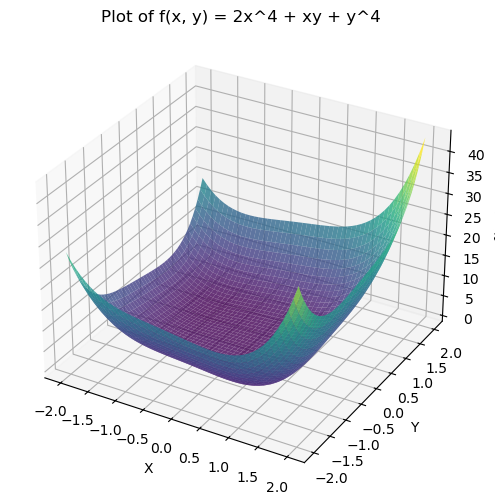

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# function
def f(x, y):
    return np.power(x, 4) + x*y + np.power(y, 4) + np.power(x, 3)

# mesh grid
x = np.linspace(-2, 2, 50)
y = np.linspace(-2, 2, 50)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# plot the surface
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(X, Y, Z, cmap = 'viridis', alpha = 0.8)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(X, Y)')
ax.set_title('Plot of f(x, y) = 2x^4 + xy + y^4')

plt.show()

### 1. Gradient Descent

In [70]:
x = 1 # an initial & random value for x
y = 1 # an initial & random value for y

for i in range(iterations):

    # setting up x and y to differenciate the function w.r.t x
    x_var = Variable(x, 1)
    y_var = Variable(y, 0)

    # partial w.r.t x
    partial_x = gradient(x_var, y_var)

    # setting up x and y to differenciate the function w.r.t y
    x_var = Variable(x, 0)
    y_var = Variable(y, 1)

    # partial w.r.t y
    partial_y = gradient(x_var, y_var)

    #########################
    
    # updating initial points
    x -= (l_r * partial_x) # x1 = x0 - (step size * partial of x)
    y -= (l_r * partial_y)

    #########################

    # define l2 norm
    l2_norm = np.sqrt(np.power(partial_x, 2) + np.power(partial_y, 2))

    if l2_norm < l2_norm_threshold:
        print('Steps to converge:', i)
        print()
        print('x value, assumed to be at optimum: {:.10f}'.format(x))
        print('y value, assumed to be at optimum: {:.10f}'.format(y))
        print()
        print('l2 norm threshold: {:.7f}'.format(l2_norm_threshold))
        print('l2 norm value: {:.7f}'.format(l2_norm))
        # we say 'assume' as the gradient may not be a perfect 0 here.
        break
        
gd_steps = i

Steps to converge: 457

x value, assumed to be at optimum: -0.9281141067
y value, assumed to be at optimum: 0.6143356836

l2 norm threshold: 0.0010000
l2 norm value: 0.0009707


### 2. GD with Momentum

Even though stochastic gradient descent (a variant of gradient descent that makes the gradient calculations more computationally efficient) proved itself as an efficient and effective optimization method that lead to many machine learning success
stories (such as the advances in deep learning), it has its limitations. For example, if the gradient reaches a saddle point, it is likely that it will stay there without being able to "jump out" and proceed to a better minimum.
<br><br>
A way these limitations are addressed is by introducing momentum. Basically SGD is enforced to keep moving in the same direction as the previous timesteps. This is done by introducing __velocity__ and __friction__.
<br>
>Velocity: Computed as the running mean of gradients, while also mentioning the direction of the gradient.
<br>
>Friction: A constant that aims to decay (ρ).
<br>

At every time step, we update our velocity by decaying the previous velocity on a factor of __ρ__ and we add the gradient of the weights on the current time. Then we update our weights in the direction of the velocity vector.

In [71]:
# extra stuff for momentum
p = 0.8 # friction or velocity coefficient (between 0 and 1)
# velocity initialization
velocity_x = 0 
velocity_y = 0 

In [72]:
x = 1 # an initial & random value for x
y = 1 # an initial & random value for y

for i in range(iterations):

    # setting up x and y to differenciate the function w.r.t x
    x_var = Variable(x, 1)
    y_var = Variable(y, 0)

    # partial w.r.t x
    partial_x = gradient(x_var, y_var)

    # setting up x and y to differenciate the function w.r.t y
    x_var = Variable(x, 0)
    y_var = Variable(y, 1)

    # partial w.r.t y
    partial_y = gradient(x_var, y_var)

    #########################################

    # adding momentum to x
    velocity_x = (p * velocity_x) + partial_x

    # updating initial point of x
    x -= (l_r * velocity_x)

    # adding momentum to y
    velocity_y = (p * velocity_y) + partial_y

    # updating initial point of y
    y -= (l_r * velocity_y)

    #########################################

    # define l2 norm
    l2_norm = np.sqrt(np.power(partial_x, 2) + np.power(partial_y, 2))

    if l2_norm < l2_norm_threshold:
        print('Steps to converge:', i)
        print()
        print('x value, assumed to be at optimum: {:.10f}'.format(x))
        print('y value, assumed to be at optimum: {:.10f}'.format(y))
        print()
        print('l2 norm threshold: {:.7f}'.format(l2_norm_threshold))
        print('l2 norm value: {:.7f}'.format(l2_norm))

        break

momentum_steps = i

Steps to converge: 82

x value, assumed to be at optimum: -0.9283478677
y value, assumed to be at optimum: 0.6145784404

l2 norm threshold: 0.0010000
l2 norm value: 0.0004455


### 3. Adagrad

This approach to gradient descent adjusts the learning rate based on the sum of past squared gradients. The intuition is that if a weight has encountered large gradients early on, its learning rate decreases over time, preventing drastic updates. Conversely, if the gradient remains small, the step size stays relatively larger. This ensures that frequently updated parameters slow down their learning, while infrequent ones retain a higher rate. However, since the learning rate only decreases, it can become too small, causing premature convergence.

In [73]:
# extra stuff for adagrad
e = 1e-8 # this is added to the denominator to prevent division by 0
# squared gradients initialization
sq_grad_x = 0
sq_grad_y = 0

In [74]:
x = 1 # an initial & random value for x
y = 1 # an initial & random value for y

for i in range(iterations):

    # setting up x and y to differenciate the function w.r.t x
    x_var = Variable(x, 1)
    y_var = Variable(y, 0)

    # partial w.r.t x
    partial_x = gradient(x_var, y_var)

    # setting up x and y to differenciate the function w.r.t y
    x_var = Variable(x, 0)
    y_var = Variable(y, 1)

    # partial w.r.t y
    partial_y = gradient(x_var, y_var)

    ##########################################################################################

    # the classic autograd update rule did not seem to converge the function
    # so i added a decay factor (which will be discusses in rmsprop) to facilitate convergence
    
    # squared gradients (required for adagrad formula)
    # sq_grad_x += partial_x * partial_x
    # sq_grad_y += partial_y * partial_y

    decay = 0.4

    sq_grad_x = decay * sq_grad_x + partial_x * partial_x
    sq_grad_y = decay * sq_grad_x + partial_y * partial_y

    # updating initial points, but this time, using adaptive gradients
    x -= l_r * (partial_x / (np.sqrt(sq_grad_x) + e))
    y -= l_r * (partial_y / (np.sqrt(sq_grad_y) + e))

    ##########################################################################################
    
    # define l2 norm
    l2_norm = np.sqrt(np.power(partial_x, 2) + np.power(partial_y, 2))

    if l2_norm < l2_norm_threshold:
        print('Steps to converge:', i)
        print()
        print('x value, assumed to be at optimum: {:.10f}'.format(x))
        print('y value, assumed to be at optimum: {:.10f}'.format(y))
        print()
        print('l2 norm threshold: {:.7f}'.format(l2_norm_threshold))
        print('l2 norm value: {:.7f}'.format(l2_norm))
        break

adagrad_steps = i

Steps to converge: 254

x value, assumed to be at optimum: -0.9280639087
y value, assumed to be at optimum: 0.6145269373

l2 norm threshold: 0.0010000
l2 norm value: 0.0007234


### 4. RMSProp

A major drawback of Adagrad is that as time goes by, the learning rate becomes smaller and smaller due to the monotonic increment of the running squared sum. (most probably this is why the function failed to converge without the decay factor, which is implemented here). This algorithm is also called "Leaky Adagrad".

In [75]:
# extra stuff for rmsprop
e = 1e-8 
sq_grad_x = 0
sq_grad_y = 0
decay = 0.9 # to reduce the influence of past gradients

In [76]:
x = 1 # an initial & random value for x
y = 2 # an initial & random value for y

for i in range(iterations):

    # setting up x and y to differenciate the function w.r.t x
    x_var = Variable(x, 1)
    y_var = Variable(y, 0)

    # partial w.r.t x
    partial_x = gradient(x_var, y_var)

    # setting up x and y to differenciate the function w.r.t y
    x_var = Variable(x, 0)
    y_var = Variable(y, 1)

    # partial w.r.t y
    partial_y = gradient(x_var, y_var)

    ###################################################################

    # leaky adagrad (aka rmsprop)
    sq_grad_x = decay * sq_grad_x + (1 - decay) * partial_x * partial_x
    sq_grad_y = decay * sq_grad_y + (1 - decay) * partial_y * partial_y

    # updating initial points
    x -= l_r * (partial_x / (np.sqrt(sq_grad_x) + e))
    y -= l_r * (partial_y / (np.sqrt(sq_grad_y) + e))

    x -= (l_r * partial_x)
    y -= (l_r * partial_y)

    ###################################################################
    
    # define l2 norm
    l2_norm = np.sqrt(np.power(partial_x, 2) + np.power(partial_y, 2))

    if l2_norm < l2_norm_threshold:
        print('Steps to converge:', i)
        print()
        print('x value, assumed to be at optimum: {:.10f}'.format(x))
        print('y value, assumed to be at optimum: {:.10f}'.format(y))
        print()
        print('l2 norm threshold: {:.7f}'.format(l2_norm_threshold))
        print('l2 norm value: {:.7f}'.format(l2_norm))
        break

rmsprop_steps = i

Steps to converge: 130

x value, assumed to be at optimum: -0.9281461624
y value, assumed to be at optimum: 0.6144869541

l2 norm threshold: 0.0010000
l2 norm value: 0.0009681


### 5. Adam

Adam combines both of the previous mentioned methods, momentum and adaptive learning rates. Hence, we keep track to two variables, velocity (from momentum) and the squared gradients (from adaptive learning rates). In the original paper, these are mentioned as __first__ and __second__ moments.

In [77]:
# extra stuff for adam
e = 1e-8 

# all the momentum related stuff
delta_one = 0.8 # friction
moment_one_x = 0 # initial velocity of x
moment_one_y = 0 # initial velocity of y
moment_one_x_unbiased = 0 # initial unbiased moment one estimate of x
moment_one_y_unbiased = 0 # initial unbiased moment one estimate of y

# all the adaptive learning rate related stuff
delta_two = 0.9 # decay
moment_two_x = 0 # initial squared gradients of x
moment_two_y = 0 # initial squared gradients of y
moment_two_x_unbiased = 0 # initial unbiased moment two estimate of x
moment_two_y_unbiased = 0 # initial unbiased moment two estimate of y

In [78]:
x = 1 # an initial & random value for x
y = 1 # an initial & random value for y

for i in range(iterations):

    # setting up x and y to differenciate the function w.r.t x
    x_var = Variable(x, 1)
    y_var = Variable(y, 0)

    # partial w.r.t x
    partial_x = gradient(x_var, y_var)

    # setting up x and y to differenciate the function w.r.t y
    x_var = Variable(x, 0)
    y_var = Variable(y, 1)

    # partial w.r.t y
    partial_y = gradient(x_var, y_var)

    #################################################################################

    # moment one 
    moment_one_x = delta_one * moment_one_x + (1 - delta_one) * partial_x 
    moment_one_y = delta_one * moment_one_y + (1 - delta_one) * partial_y

    # moment two 
    moment_two_x = delta_two * moment_two_x + (1 - delta_two) * partial_x * partial_x
    moment_two_y = delta_two * moment_two_y + (1 - delta_two) * partial_y * partial_y

    # print(moment_one_x, moment_one_y)

    # moment one unbiased
    moment_one_x_unbiased = moment_one_x / (1 - np.power(delta_one, i + 1))
    moment_one_y_unbiased = moment_one_y / (1 - np.power(delta_one, i + 1))

    # moment two unbiased
    moment_two_x_unbiased = moment_two_x / (1 - np.power(delta_two, i + 1))
    moment_two_y_unbiased = moment_two_y / (1 - np.power(delta_two, i + 1))

    # updating initial points
    x -= l_r * (moment_one_x_unbiased / (np.sqrt(moment_two_x_unbiased) + e))
    y -= l_r * (moment_one_y_unbiased / (np.sqrt(moment_two_y_unbiased) + e))

    #################################################################################
    
    # define l2 norm
    l2_norm = np.sqrt(np.power(partial_x, 2) + np.power(partial_y, 2))

    if l2_norm < l2_norm_threshold:
        print('Steps to converge:', i)
        print()
        print('x value, assumed to be at optimum: {:.10f}'.format(x))
        print('y value, assumed to be at optimum: {:.10f}'.format(y))
        print()
        print('l2 norm threshold: {:.7f}'.format(l2_norm_threshold))
        print('l2 norm value: {:.7f}'.format(l2_norm))
        break

adam_steps = i

Steps to converge: 204

x value, assumed to be at optimum: 0.3175414247
y value, assumed to be at optimum: -0.4302797055

l2 norm threshold: 0.0010000
l2 norm value: 0.0007221


### 6. AdaMax

A variant of Adam that replaces the L2 norm (RMS) of past gradients with the L infinity norm (max absolute gradient value).

In [79]:
# extra stuff for adam
e = 1e-8 

# all the momentum related stuff
delta_one = 0.8 # friction
moment_one_x = 0 # initial velocity of x
moment_one_y = 0 # initial velocity of y

# all the weighted infinity norm related stuff
delta_two = 0.9
in_x = 0
in_y = 0

In [80]:
x = 1 # an initial & random value for x
y = 1 # an initial & random value for y

for i in range(1, iterations + 1):

    # setting up x and y to differenciate the function w.r.t x
    x_var = Variable(x, 1)
    y_var = Variable(y, 0)

    # partial w.r.t x
    partial_x = gradient(x_var, y_var)

    # setting up x and y to differenciate the function w.r.t y
    x_var = Variable(x, 0)
    y_var = Variable(y, 1)

    # partial w.r.t y
    partial_y = gradient(x_var, y_var)

    #######################################################################

    # moment one
    moment_one_x = delta_one * moment_one_x + (1 - delta_one) * partial_x
    moment_one_y = delta_one * moment_one_y + (1 - delta_one) * partial_y

    # infinity norm
    in_x = max(delta_two * in_x, abs(partial_x))
    in_y = max(delta_two * in_y, abs(partial_y))

    # updating initial points
    x -= (l_r / (1 - np.power(delta_one, i))) * (moment_one_x / (in_x + e))
    y -= (l_r / (1 - np.power(delta_one, i))) * (moment_one_y / (in_y + e))

    #######################################################################

    # define l2 norm
    l2_norm = np.sqrt(np.power(partial_x, 2) + np.power(partial_y, 2))

    if l2_norm < l2_norm_threshold:
        print('Steps to converge:', i)
        print()
        print('x value, assumed to be at optimum: {:.10f}'.format(x))
        print('y value, assumed to be at optimum: {:.10f}'.format(y))
        print()
        print('l2 norm threshold: {:.7f}'.format(l2_norm_threshold))
        print('l2 norm value: {:.7f}'.format(l2_norm))
        break

adamax_steps = i

Steps to converge: 271

x value, assumed to be at optimum: -0.9271951806
y value, assumed to be at optimum: 0.6138420611

l2 norm threshold: 0.0010000
l2 norm value: 0.0007446


### 7. AdaBelief

Modifies Adam’s second moment estimate by tracking how much the gradients deviate from their predicted mean instead of their raw magnitude.

In [81]:
# extra stuff for adabelief
e = 1e-8 

# all the momentum related stuff
delta_one = 0.8 # friction
moment_one_x = 0 # initial velocity of x
moment_one_y = 0 # initial velocity of y
moment_two_x = 0 # initial something of x
moment_two_y = 0 # initial something of y

# all the weighted infinity norm related stuff
delta_two = 0.9
in_x = 0
in_y = 0

In [82]:
x = 1 # an initial & random value for x
y = 1 # an initial & random value for y

for i in range(iterations):

    # setting up x and y to differenciate the function w.r.t x
    x_var = Variable(x, 1)
    y_var = Variable(y, 0)

    # partial w.r.t x
    partial_x = gradient(x_var, y_var)

    # setting up x and y to differenciate the function w.r.t y
    x_var = Variable(x, 0)
    y_var = Variable(y, 1)

    # partial w.r.t y
    partial_y = gradient(x_var, y_var)

    ###################################################################################################################

    # moment one 
    moment_one_x = delta_one * moment_one_x + (1 - delta_one) * partial_x 
    moment_one_y = delta_one * moment_one_y + (1 - delta_one) * partial_y

    # moment two 
    moment_two_x = delta_two * moment_two_x + (1 - delta_two) * (partial_x - moment_two_x) * (partial_x - moment_two_x)
    moment_two_y = delta_two * moment_two_y + (1 - delta_two) * (partial_y - moment_two_y) * (partial_y - moment_two_y)

    # moment one unbiased
    moment_one_x_unbiased = moment_one_x / (1 - np.power(delta_one, i + 1))
    moment_one_y_unbiased = moment_one_y / (1 - np.power(delta_one, i + 1))

    # moment two unbiased
    moment_two_x_unbiased = moment_two_x / (1 - np.power(delta_two, i + 1))
    moment_two_y_unbiased = moment_two_y / (1 - np.power(delta_two, i + 1))

    # updating initial points
    x -= l_r * (moment_one_x_unbiased / (np.sqrt(moment_two_x_unbiased) + e))
    y -= l_r * (moment_one_y_unbiased / (np.sqrt(moment_two_y_unbiased) + e))

    ###################################################################################################################
    
    # define l2 norm
    l2_norm = np.sqrt(np.power(partial_x, 2) + np.power(partial_y, 2))

    if l2_norm < l2_norm_threshold:
        print('Steps to converge:', i)
        print()
        print('x value, assumed to be at optimum: {:.10f}'.format(x))
        print('y value, assumed to be at optimum: {:.10f}'.format(y))
        print()
        print('l2 norm threshold: {:.7f}'.format(l2_norm_threshold))
        print('l2 norm value: {:.7f}'.format(l2_norm))
        break

adabelief_steps = i

Steps to converge: 156

x value, assumed to be at optimum: -0.9291315947
y value, assumed to be at optimum: 0.6147001413

l2 norm threshold: 0.0010000
l2 norm value: 0.0005423


### Summary

In [84]:
print('Results:')
print()
print('Steps took by Gradient Descent to converge:\t', gd_steps)
print('Steps took by GD with Momentum to converge:\t', momentum_steps)
print('Steps took by Adagrad to converge:\t\t', adagrad_steps)
print('Steps took by RMSProp to converge:\t\t', rmsprop_steps)
print('Steps took by Adam to converge:\t\t\t', adam_steps)
print('Steps took by AdaMax to converge:\t\t', adamax_steps)
print('Steps took by AdaBelief to converge:\t\t', adabelief_steps)

Results:

Steps took by Gradient Descent to converge:	 457
Steps took by GD with Momentum to converge:	 82
Steps took by Adagrad to converge:		 254
Steps took by RMSProp to converge:		 130
Steps took by Adam to converge:			 204
Steps took by AdaMax to converge:		 271
Steps took by AdaBelief to converge:		 156
